In [1]:
from hest import iter_hest, XeniumReader
from hest.HESTData import *
from hest import h5ad_reader
from hest.h5ad_reader import *
import dask
from pathlib import Path
import scanpy as sc

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import math

In [120]:
# ---- Base folder ----
base_root = Path("/project/simmons_hts/kxu/hest/xenium_data")

# Datasets to inspect
datasets = [f"XeniumR{i}" for i in range(1, 7)]

# ---- Parameters ----
cols = 4         # number of columns in grid
max_show = 16    # limit per dataset (set None for all)
thumb_size = (800, 800)  # resize to speed up plotting

for ds in datasets:
    ds_dir = base_root / ds
    if not ds_dir.exists():
        print(f"⚠️ {ds_dir} not found, skipping.")
        continue

    found = sorted(ds_dir.rglob("spatial_plots.png"))
    if not found:
        print(f"⚠️ No spatial_plots.png found in {ds_dir}")
        continue

    if max_show:
        found = found[:max_show]

    print(f"🧩 {ds}: visualising {len(found)} plots")

    # --- build grid ---
    rows = math.ceil(len(found) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for i, (ax, path) in enumerate(zip(axes, found)):
        try:
            img = Image.open(path)
            img.thumbnail(thumb_size)
            ax.imshow(img)
            rel = path.relative_to(ds_dir)
            ax.set_title(str(rel.parent), fontsize=8)
            ax.axis("off")
        except Exception as e:
            ax.axis("off")
            ax.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center", fontsize=8)

    # hide unused subplots
    for j in range(len(found), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()

    # --- save to PDF under dataset folder ---
    out_pdf = ds_dir / "spatial_plots.pdf"
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.close(fig)
    print(f"✔ Saved grid to {out_pdf}\n")

print("✅ Done generating all spatial_plots.pdf files.")


# local edits: crop spots

In [14]:
# keep original function
_orig_calc_qc = sc.pp.calculate_qc_metrics

try:
    # replace with a no-op
    sc.pp.calculate_qc_metrics = lambda *args, **kwargs: None

    # call read_HESTData — it will skip Scanpy's QC (but your adata already has QC columns)
    st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
    print("read_HESTData succeeded -> st created:", type(st), bool(st))
finally:
    # restore original function
    sc.pp.calculate_qc_metrics = _orig_calc_qc

read_HESTData succeeded -> st created: <class 'hest.HESTData.HESTData'> True


## XeniumR1S1ROI4

In [97]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR1/slide1/ROI4")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

/package/python-cbrg/current/3.11.11/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:426: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


        'pixel_size' is 0.22035058607882274
        'wsi' is <width=38817, height=29960, backend=OpenSlideWSI>
        'shapes': []

In [100]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type': 'trapezoid','orientation': 'left','top_width': 0.31,'bottom_width': 0.03,'center_offset': -0.5,'height': 0.75
     ,'units': 'frac'},
    {'type':'corner', 'corner':'top-left', 'width':0.52, 'height':0.1, 'units':'frac'},
    #{'type':'corner', 'corner':'bottom-right', 'width':0.18, 'height':0.4, 'units':'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)

Spots kept after rules: 4970 / 4986


/tmp/ipykernel_660463/3420053887.py:23: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


saving to pyramidal tiff... can be slow


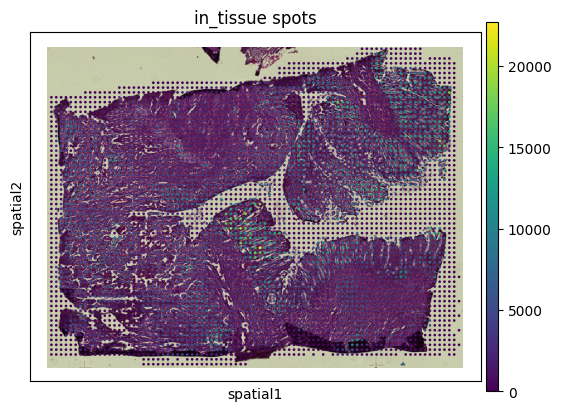

In [102]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

## XeniumR2S2ROI8

In [103]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR2/slide2/ROI8")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

/package/python-cbrg/current/3.11.11/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:426: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


        'pixel_size' is 0.22053320323072262
        'wsi' is <width=20326, height=24928, backend=OpenSlideWSI>
        'shapes': []

In [117]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type':'corner', 'corner':'bottom-left', 'width':0.52, 'height':0.04, 'units':'frac'},
    {'type':'corner', 'corner':'bottom-right', 'width':0.5, 'height':0.06, 'units':'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)

In [118]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

## XeniumR5S2ROI8

In [4]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR5/slide2/ROI8")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

        'pixel_size' is 0.22050955029388286
        'wsi' is <width=26059, height=29207, backend=OpenSlideWSI>
        'shapes': []

Spots kept after rules: 3532 / 3632


/tmp/ipykernel_724534/2202956987.py:20: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


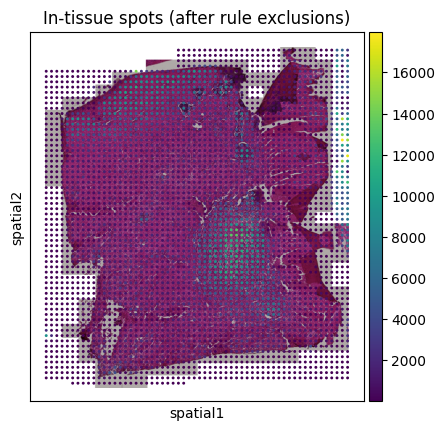

In [27]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type':'corner', 'corner':'top-left', 'width':0.42, 'height':0.06, 'units':'frac'},
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)

In [ ]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


saving to pyramidal tiff... can be slow


## XeniumR5S2ROI9

In [30]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR5/slide2/ROI9")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

/package/python-cbrg/current/3.11.11/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:426: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


        'pixel_size' is 0.22120765892026445
        'wsi' is <width=17449, height=19529, backend=OpenSlideWSI>
        'shapes': []

Spots kept after rules: 1564 / 1593


/tmp/ipykernel_724534/1725200579.py:20: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


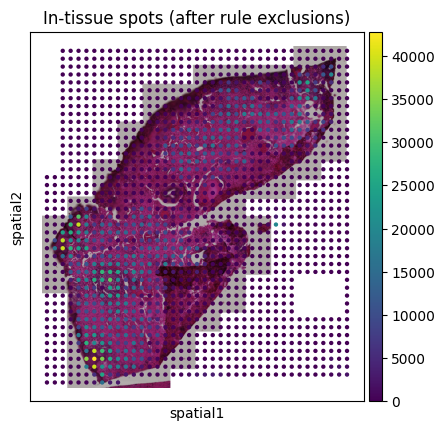

In [33]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type':'corner', 'corner':'bottom-right', 'width':0.73, 'height':0.02, 'units':'frac'},
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)

In [34]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

## XeniumR6S1ROI1

In [36]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR6/slide1/ROI1")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

/package/python-cbrg/current/3.11.11/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:426: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


        'pixel_size' is 0.22052311639419295
        'wsi' is <width=23204, height=31393, backend=OpenSlideWSI>
        'shapes': []

In [ ]:
%matplotlib inline
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type': 'trapezoid','orientation': 'left','top_width': 0.1,'bottom_width': 0.001,'center_offset': -0.5,'height': 0.7
     ,'units': 'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)


Spots kept after rules: 2192 / 2192


/tmp/ipykernel_750790/3841840026.py:22: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


In [ ]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

## XeniumR6S1ROI2

In [47]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR6/slide1/ROI2")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

        'pixel_size' is 0.2204794992378835
        'wsi' is <width=26058, height=22774, backend=OpenSlideWSI>
        'shapes': []

Spots kept after rules: 2484 / 2484


/tmp/ipykernel_750790/1666213654.py:22: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


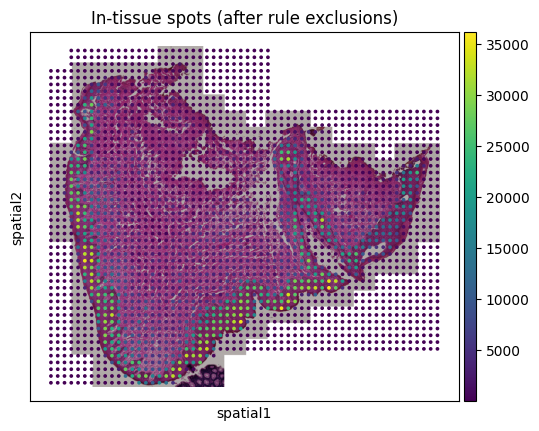

/tmp/ipykernel_750790/1666213654.py:30: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",


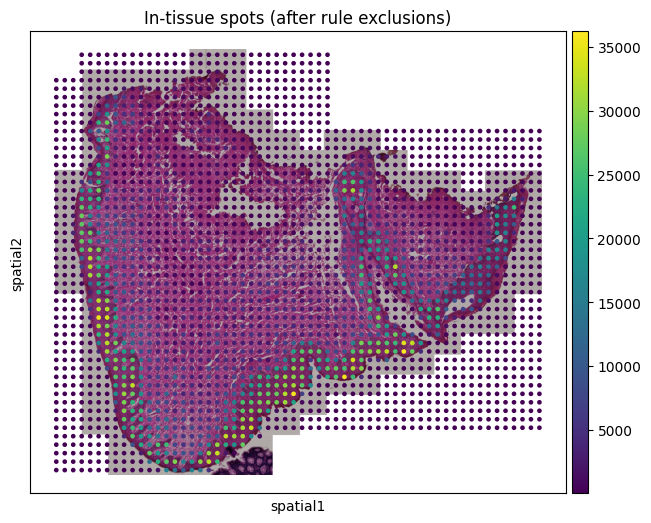

In [ ]:
%matplotlib inline
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type': 'trapezoid','orientation': 'bottom','top_width': 0.95,'bottom_width': 0.7,'center_offset': 0.28,'height': 0.1
     ,'units': 'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)

# now plot (smaller image -> smaller fig)
fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",
                    color="total_counts", title="In-tissue spots (after rule exclusions)",
                    return_fig=True, show=False)
fig.set_size_inches(8,6)
fig.canvas.draw()
display(fig)
plt.show()

In [ ]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


saving to pyramidal tiff... can be slow


## XeniumR6S1ROI6

In [80]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR6/slide1/ROI6")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

        'pixel_size' is 0.2203912629752772
        'wsi' is <width=49085, height=23886, backend=OpenSlideWSI>
        'shapes': []

Spots kept after rules: 5433 / 5609


/tmp/ipykernel_750790/2860637702.py:20: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",


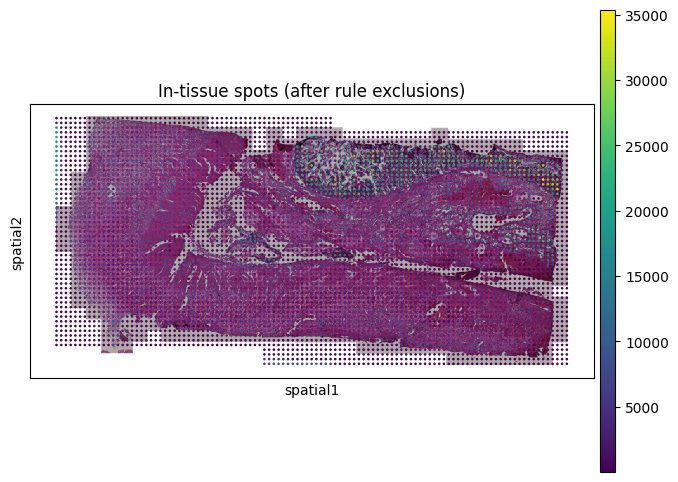

In [ ]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type':'corner', 'corner':'bottom-left', 'width':0.4, 'height':0.07, 'units':'frac'},
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# now plot (smaller image -> smaller fig)
fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",
                    color="total_counts", title="In-tissue spots (after rule exclusions)",
                    return_fig=True, show=False)
fig.set_size_inches(8,6)
fig.canvas.draw()
display(fig)
plt.show()

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


saving to pyramidal tiff... can be slow


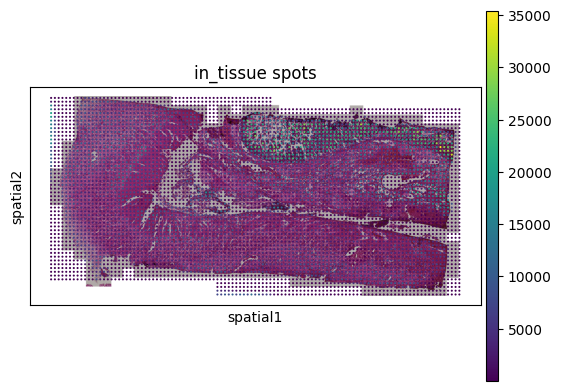

In [92]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

# XeniumR6S2ROI8

In [93]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR6/slide2/ROI8")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

        'pixel_size' is 0.22046323752819308
        'wsi' is <width=39010, height=17408, backend=OpenSlideWSI>
        'shapes': []

Spots kept after rules: 3107 / 3243


/tmp/ipykernel_750790/2025000312.py:20: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",


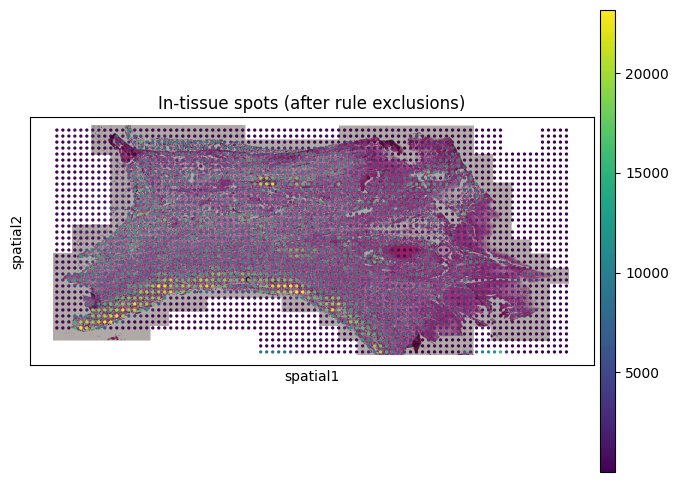

In [ ]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type':'corner', 'corner':'bottom-left', 'width':0.4, 'height':0.1, 'units':'frac'},
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# now plot (smaller image -> smaller fig)
fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",
                    color="total_counts", title="In-tissue spots (after rule exclusions)",
                    return_fig=True, show=False)
fig.set_size_inches(8,6)
fig.canvas.draw()
display(fig)
plt.show()

In [ ]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


saving to pyramidal tiff... can be slow


# XeniumR6S2ROI9

In [2]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR6/slide2/ROI9")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

/home/k/kxu/.local/lib/python3.11/site-packages/hestcore/wsi.py:27: UserWarning: CuImage is not available. Ensure you have a GPU and cucim installed to use GPU acceleration.
  warnings.warn("CuImage is not available. Ensure you have a GPU and cucim installed to use GPU acceleration.")


        'pixel_size' is 0.22055790383067717
        'wsi' is <width=30374, height=35707, backend=OpenSlideWSI>
        'shapes': []

Spots kept after rules: 4857 / 5055


/tmp/ipykernel_2791091/3883446436.py:21: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",


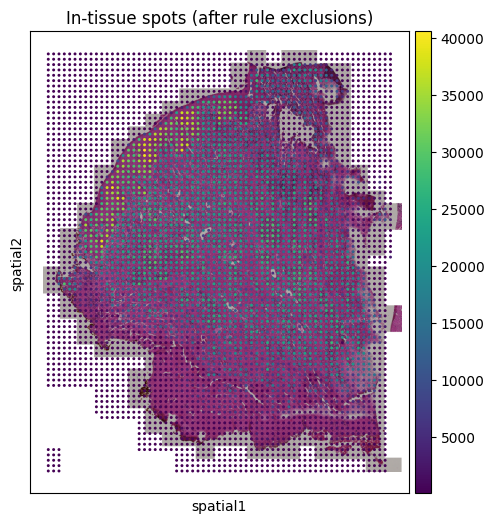

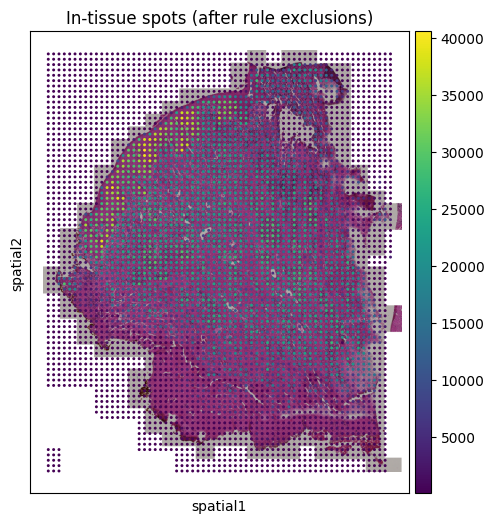

In [4]:
# --- spot exclusions across full WSI (no cell bbox restriction) ---
# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {'type':'strip', 'side':'right', 'size':0.03, 'units':'frac'},
    {'type':'corner', 'corner':'bottom-right', 'width':0.04, 'height':0.5, 'units':'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# now plot (smaller image -> smaller fig)
fig = sc.pl.spatial(st.adata[final_keep], img_key="downscaled_fullres",
                    color="total_counts", title="In-tissue spots (after rule exclusions)",
                    return_fig=True, show=False)
fig.set_size_inches(8,6)
fig.canvas.draw()
display(fig)
plt.show()

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


saving to pyramidal tiff... can be slow


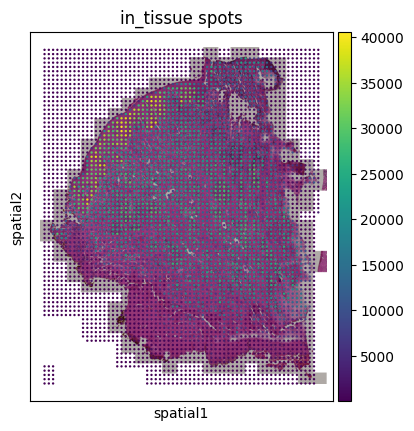

In [5]:
st.adata = st.adata[final_keep] # only when confirmed bounding box

st.save_spatial_plot(out_dir)
st.save(out_dir, pyramidal=True)